In [2]:
import math
import copy
import random

import numpy as np
import pandas as pd
import igraph
from igraph import Graph, summary
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import seaborn as sns

In [3]:
stations = pd.read_csv('data/stations.csv')
stations.set_index('id', inplace=True)
stations_connections = pd.read_csv('data/stations_connections.csv')
lines = pd.read_csv('data/lines.csv')

In [4]:
underground = Graph()
underground.add_vertices(310)
connections = [(row['station1'], row['station2']) for idx, row in stations_connections.iterrows()]
underground.add_edges(connections)

In [5]:
def get_path(finish, parent, graph=Graph()):
  path = [finish, parent]
  while True:
    parent = graph.vs[parent]['parent']
    if parent == 'NULL':
      break
    path.append(parent)
  return path

(15,
 [6, 46, 53, 214, 168, 179, 180, 199, 184, 115, 291, 210, 235, 251, 252, 5])

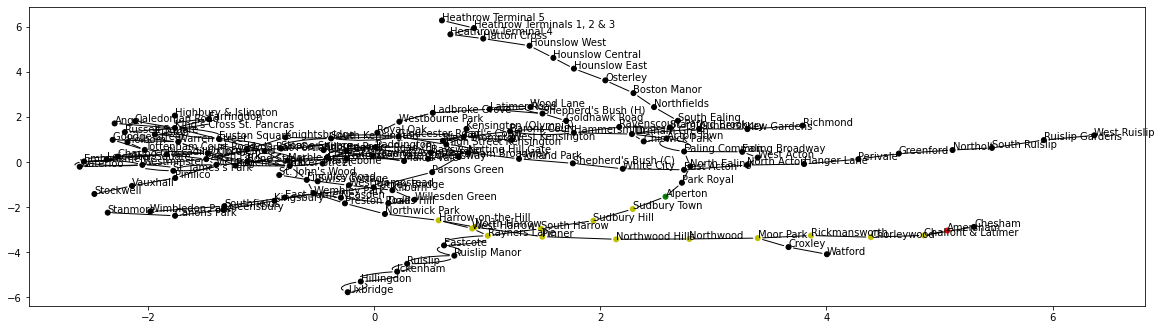

In [14]:
def dijkstra(graph, start, finish, plot=False):
    working_graph = graph.copy()
    working_graph.vs['distance'] = math.inf
    working_graph.vs[start]['distance'] = 0
    working_graph.vs[start]['parent'] = 'NULL'

    Q = list(working_graph.vs())
    
    while Q:
      min_distance = np.argmin([vertex['distance'] for vertex in Q])
      v = Q.pop(min_distance)
      if v.index == finish:
        path = get_path(finish, v['parent'], working_graph)
        break
      for neighbor in v.neighbors():
        update_distance = v['distance'] + 1
        if update_distance < neighbor['distance']:
          neighbor['distance'] = update_distance
          neighbor['parent'] = v.index
          
    if plot:
      shortest_dist = working_graph.vs[finish]['distance']
      sub_vertices = working_graph.vs.select(distance_le=shortest_dist).indices
      reduced_graph = underground.induced_subgraph(sub_vertices)

      colors = np.repeat('black', 310)
      colors[path] = 'y'
      colors[start], colors[finish] = 'green', 'red'

      layout = reduced_graph.layout("kk")
      fig, ax = plt.subplots()
      plt.rcParams["figure.figsize"] = (20,5.5)
      igraph.plot(reduced_graph, layout=layout, target=ax, vertex_label=stations.loc[sub_vertices].name, vertex_color=colors[sub_vertices])

    return working_graph.vs[finish]['distance'], path


dijkstra(underground, 5, 6, True)

In [7]:
def compute_haversine(station1, station2):
  start_cords = stations.loc[station1][['latitude','longitude']].values
  start_cords = [radians(_) for _ in start_cords]
  finish_cords = stations.loc[station2][['latitude','longitude']].values
  finish_cords = [radians(_) for _ in finish_cords]
  return haversine_distances([start_cords, finish_cords])[0][1] * 6371000/1000

In [8]:
def a_star(graph, start, finish):
  working_graph = graph.copy()
  working_graph.vs['g_distance'] = math.inf
  working_graph.vs[start]['g_distance'] = 0 
  working_graph.vs[start]['parent'] = 'NULL'

  O = [working_graph.vs[start]]
  C = []

  while O:
    min_distance = np.argmin([compute_haversine(vertex.index, finish)+vertex['g_distance'] for vertex in O])
    if O[min_distance].index == finish:
      path = get_path(finish, O[min_distance]['parent'], working_graph)
      return O[min_distance]['g_distance'], path
    else:
      v = O.pop(min_distance)
      for neighbor in v.neighbors():
        update_distance = v['g_distance'] + 1
        if update_distance < neighbor['g_distance']:
           neighbor['g_distance'] = update_distance
           neighbor['parent'] = v.index
        if neighbor['g_distance'] + 1 < v['g_distance']:
          v['g_distance'] = neighbor['g_distance'] + 1
          v['parent'] = neighbor.index
        if neighbor.index not in [_.index for _ in O] and neighbor.index not in [_.index for _ in C]:
          O.append(neighbor)
      C.append(v)
  
a_star(underground, 5, 6)

(15,
 [6, 46, 53, 214, 168, 179, 180, 199, 184, 115, 291, 210, 235, 251, 252, 5])

In [9]:
dist, stations_p = a_star(underground, 5, 6)
stations.loc[stations_p]

,latitude,longitude,name,display_name,zone,total_lines,rail
id,,,,,,,
6,51.6736,-0.6070,Amersham,NaN,9.0,1,1
46,51.6679,-0.5610,Chalfont & Latimer,Chalfont &<br />Latimer,8.0,1,1
53,51.6543,-0.5183,Chorleywood,NaN,7.0,1,0
214,51.6404,-0.4733,Rickmansworth,NaN,7.0,1,0
168,51.6294,-0.4320,Moor Park,Moor<br />Park,6.5,1,0
179,51.6111,-0.4240,Northwood,NaN,6.0,1,0
180,51.6004,-0.4092,Northwood Hills,Northwood<br />Hills,6.0,1,0
199,51.5926,-0.3805,Pinner,NaN,5.0,1,0
184,51.5846,-0.3626,North Harrow,North<br />Harrow,5.0,1,0


In [10]:
def generate_routes(num_agents):
    blocks = []
    finishes = []
    for num in range(num_agents):
        block = random.randint(1,309)
        while block in blocks or block == 189:
            block = random.randint(1,309)
        finish = random.randint(1,309)
        while finish in [block, 189] or finish in finishes:
            finish = random.randint(1,309)
        blocks.append(block)
        finishes.append(finish)
    return blocks, finishes

generate_routes(3)

([148, 7, 75], [163, 246, 217])

In [15]:
def conflict_exists(path1, path2, reason):
    shorter = min(len(path1), len(path2))
    if reason == 'distinct_paths':
        return bool(set(path1).intersection(set(path2)))
    if reason == 'same_vertex':
        for idx in range(shorter):
            if path1[-idx] == path2[-idx]:
                return True
        return False
    if reason == 'following':
        if conflict_exists(path1, path2, 'same_vertex'):
            return True
        if len(path1) == shorter:
            for idx, vertex in enumerate(path1[-2::-1]):
                if vertex == path2[::-1][idx]:
                    return True
        if len(path2) > len(path1):
            for idx, vertex in enumerate(path2[-2:-(shorter+1):-1]):
                if vertex == path1[::-1][idx]:
                    return True
        return False


In [16]:
def mapf(graph, blocks, finishes, algorithm, reason='same_vertex'):
    lengths = []
    paths = []
    for idx, starting_point in enumerate(blocks):
        if algorithm == 'a_star':
            length, path = a_star(graph, starting_point, finishes[idx])
        if algorithm == 'dijkstra':
            length, path = dijkstra(graph, starting_point, finishes[idx])        
        lengths.append(length)
        paths.append(path)


    is_conflict = np.zeros(shape=(len(blocks), len(finishes)))
    for idx, path1 in enumerate(paths):
        for idy, path2 in enumerate(paths[idx+1:], idx+1):
            is_conflict[idx][idy] = conflict_exists(path1, path2, reason)
  
    is_conflict = np.any(is_conflict == 1)
    return lengths, paths, is_conflict

blocks, finishes = generate_routes(2)
mapf(underground, blocks, finishes, 'a_star')

([7, 15],
 [[190, 30, 176, 234, 1, 265, 242, 209],
  [64, 135, 171, 61, 238, 120, 42, 41, 23, 157, 13, 279, 285, 248, 273, 229]],
 False)

In [35]:
num_routes = []
num_conflicts = []

for num in range(2, 25):
    was_conflict = []
    for iteration in range(20):
        blocks, finishes = generate_routes(num)
        conflict = mapf(underground, blocks, finishes, 'dijkstra', 'following')[2]
        was_conflict.append(conflict)
    num_conflicts.append(np.mean(was_conflict)*100)
    num_routes.append(num)

Text(0, 0.5, 'Percentage of conflicts (%)')

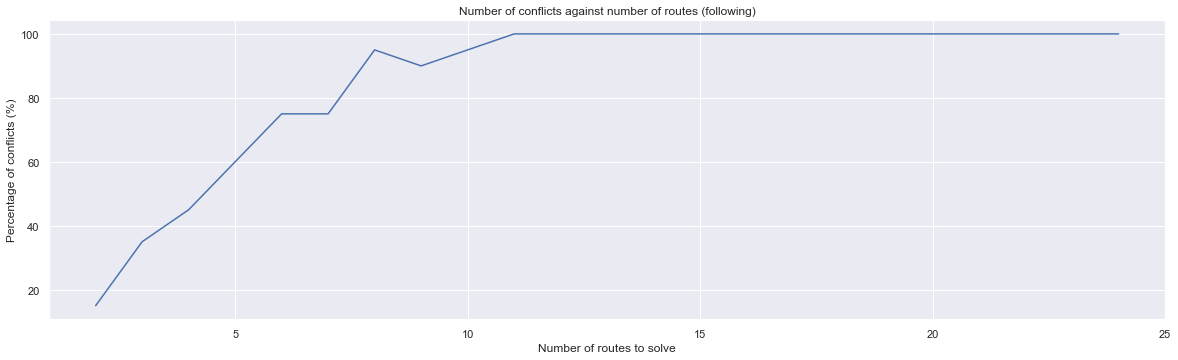

In [36]:
sns.set_theme()
plt.plot(num_routes, num_conflicts)
plt.xlim(1,25)
plt.title('Number of conflicts against number of routes (following)')
plt.xlabel('Number of routes to solve')
plt.ylabel('Percentage of conflicts (%)')

In [ ]:
path_weights = np.zeros(shape=(310, 310))
for idx, _ in enumerate(path_weights):
    if idx in [0, 189]:
        continue
    for idy, _ in enumerate(path_weights[idx][idx+1:], idx+1):
        if idy in [0, 189]:
            continue
        print(idx, idy)
        path_weights[idx][idy] = dijkstra(underground, idx, idy)[0]

In [ ]:
path_weights2 = np.zeros(shape=(310, 310))
for idx, _ in enumerate(path_weights2):
    if idx in [0, 189]:
        continue
    for idy, _ in enumerate(path_weights2[idx][idx+1:], idx+1):
        if idy in [0, 189]:
            continue
        path_weights2[idx][idy] = dijkstra(underground, idx, idy)[0]

In [ ]:
path_weights3 = np.zeros(shape=(310, 310))
for idx, _ in enumerate(path_weights3):
    if idx in [0, 189]:
        continue
    for idy, _ in enumerate(path_weights3[idx][idx+1:], idx+1):
        if idy in [0, 189]:
            continue
        print(idx, idy)
        path_weights3[idx][idy] = a_star(underground, idx, idy)[0]